### Import packages

In [1]:
import pandas as pd
import numpy as np
from os.path import join as pjoin

import matplotlib.pyplot as plt
import matplotlib as mpl
from spks.event_aligned import population_peth
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', 100)

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['font.size'] = 12

%matplotlib widget
%load_ext autoreload
%autoreload 2

### Load neural and behavioral data

In [2]:
animal = 'GRB006'  # example animal
session = '20240723_142451'  # example session

data_dir = '/Users/gabriel/data'
trial_ts = pd.read_pickle(pjoin(data_dir, animal, session, "pre_processed", "trial_ts.pkl"))
spike_times_per_unit = np.load(pjoin(data_dir, animal, session, "pre_processed", "spike_times_per_unit.npy"), allow_pickle=True)

### Make design matrix

In [3]:
def make_design_matrix(trial_ts, spike_times_per_unit, post_seconds, bin_size=0.025):
    all_stims = np.hstack(np.array(trial_ts.stim_ts.dropna()))
    start_time = all_stims[0]
    end_time = all_stims[-1] + post_seconds
    time_bins = np.arange(start_time, end_time + bin_size, bin_size)
    combined_bins = np.union1d(time_bins, all_stims)
    combined_bins.sort()
    time_bins = combined_bins
    
    n_units = len(spike_times_per_unit)
    n_bins = len(time_bins) - 1
    binned_spike_rate = np.zeros((n_bins, n_units))
    for unit_idx, stimes in enumerate(spike_times_per_unit):
        counts, _ = np.histogram(stimes, bins=time_bins)
        binned_spike_rate[:, unit_idx] = counts / bin_size
    
    stim_indicator = np.zeros(n_bins)
    stim_indices = np.searchsorted(time_bins[:-1], all_stims, side='right') - 1
    stim_indicator[stim_indices] = 1
    
    tolerance = 1e-6
    retrieved_stim_times = time_bins[stim_indices]
    time_differences = all_stims - retrieved_stim_times
    alignment_check = np.all(np.abs(time_differences) < tolerance)
    
    if alignment_check:
        n_timepoints = int(round(post_seconds / bin_size))
        design_matrix = np.zeros((n_bins, n_timepoints))
        for lag in range(n_timepoints):
            if lag == 0:
                design_matrix[:, lag] = stim_indicator
            else:
                design_matrix[lag:, lag] = stim_indicator[:-lag]
        return design_matrix, binned_spike_rate, all_stims, n_timepoints, time_bins
    else:
        print("Alignment issue detected. Please check time_bins and stim_times.")
        return None, None

post_seconds = 0.15
bin_size = 0.050
design_matrix, binned_spike_rate, all_stims, n_timepoints, time_bins = make_design_matrix(trial_ts, spike_times_per_unit, post_seconds=post_seconds, bin_size=bin_size)
n_samples = binned_spike_rate.shape[0]
n_units = binned_spike_rate.shape[1]

#### Design matrix viz

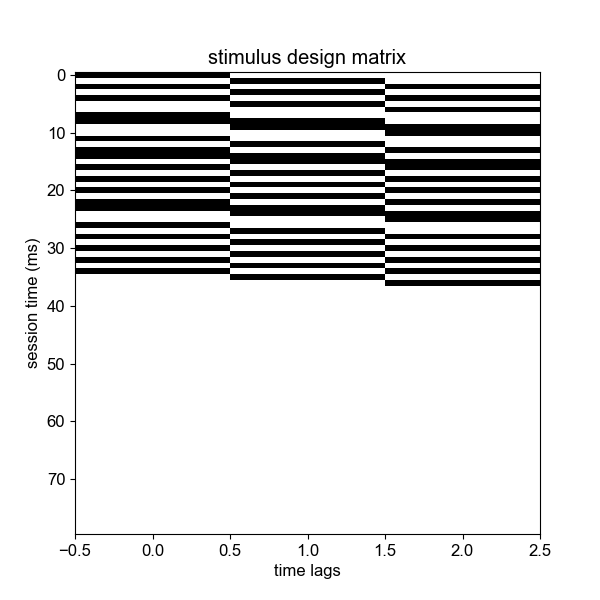

In [4]:
import os
from os.path import join as pjoin

save_dir = '/Users/gabriel/Desktop/new_encoding_model/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

plt.figure(figsize=(6, 6))
plt.imshow(design_matrix[0:80, :], aspect='auto', cmap='gray_r')
plt.xlabel('time lags')
plt.ylabel('session time (ms)')
plt.title('stimulus design matrix')
# plt.savefig(pjoin(save_dir, "stimulus_design_matrix.svg"), format='svg', dpi=300, bbox_inches='tight')
plt.show()

### Fit a linear model for the population

In [5]:
from sklearn.model_selection import KFold
from spks.utils import alpha_function
binsize = bin_size
t_decay = 0.025
t_rise = 0.001
decay = t_decay / binsize
kern = alpha_function(int(decay * 15), t_rise=t_rise, t_decay=decay, srate=1./binsize)

smoothed_binned_spike_rate = np.zeros_like(binned_spike_rate)
for unit_idx in range(n_units):
    unit_spikes = binned_spike_rate[:, unit_idx]
    smoothed_binned_spike_rate[:, unit_idx] = np.convolve(unit_spikes, kern, mode='same')

X = design_matrix
y = smoothed_binned_spike_rate
y = (y - y.mean(axis=0, keepdims=True)) / y.std(axis=0, keepdims=True) # z-score the response matrix

n_folds = 10
kf = KFold(n_splits = n_folds, shuffle = True)

models = []
models_shuffle = []
cv_R_squared = []
cv_R_squared_shuffle = []

for i, (train_index, test_index) in enumerate(kf.split(X = X, y = y)): 
    X_train, X_test = X[train_index], X[test_index]
    X_train_shuffled = X_train[np.random.permutation(X_train.shape[0]),:]
    y_train, y_test = y[train_index], y[test_index]

    models.append(LinearRegression(fit_intercept=True).fit(X=X_train, y=y_train))
    models_shuffle.append(LinearRegression(fit_intercept=True).fit(X=X_train_shuffled, y=y_train))
    cv_R_squared.append(models[-1].score(X_test, y_test))  
    cv_R_squared_shuffle.append(models_shuffle[-1].score(X_test, y_test))

best_model = np.where(np.array(cv_R_squared) == np.max(cv_R_squared))[0][0]

In [6]:
print(f"best model performance: {np.round(cv_R_squared[best_model], 2)}")

best model performance: 0.01


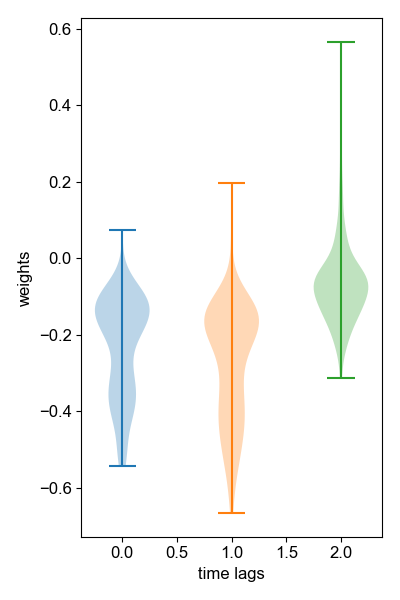

In [7]:
unit_weights = models[best_model].coef_
plt.figure(figsize=(4, 6))
for timepoint in range(unit_weights.shape[1]):
    plt.violinplot(unit_weights[:, timepoint], positions=[timepoint])
plt.xlabel('time lags')
plt.ylabel('weights')
plt.tight_layout()

/var/folders/k4/_l1cqd4d0gn02n75d0rrj10h0000gr/T/ipykernel_8922/3242453961.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


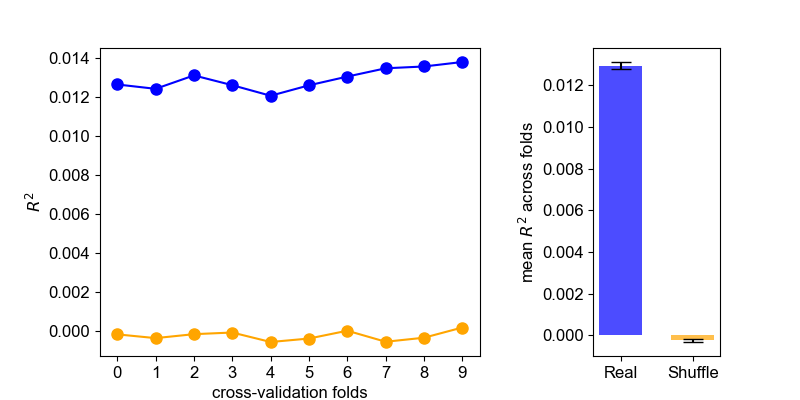

In [8]:
import numpy as np
from scipy import stats

# Plot the R² per fold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [3, 1], 'wspace': 0.45})

# Line plot showing R² across folds
ax1.plot(cv_R_squared, 'o-', label='real', color='blue', markersize=8)
ax1.plot(np.array(cv_R_squared_shuffle), 'o-', label='shuffle', color='orange', markersize=8)
ax1.set_ylabel('$R^2$')
ax1.set_xlabel('cross-validation folds')
ax1.set_xticks(np.arange(0, n_folds))

# Bar plot showing mean R² values
bar_positions = [0, 1]
bar_heights = [np.mean(cv_R_squared), np.mean(cv_R_squared_shuffle)]
bar_errors = [stats.sem(cv_R_squared), stats.sem(cv_R_squared_shuffle)]

bars = ax2.bar(bar_positions, bar_heights, yerr=bar_errors, width=0.6, 
    color=['blue', 'orange'], capsize=7, alpha=0.7)
ax2.set_xticks(bar_positions)
ax2.set_xticklabels(['Real', 'Shuffle'])
ax2.set_ylabel('mean $R^2$ across folds')

plt.tight_layout()
# plt.savefig(pjoin(save_dir, "movement_stimulus_model_scores_across_folds.svg"), format='svg', dpi=300, bbox_inches='tight')


### Fitting a model for every unit independently

In [9]:
from sklearn.model_selection import KFold
from spks.utils import alpha_function
binsize = bin_size
t_decay = 0.025
t_rise = 0.001
decay = t_decay / binsize
kern = alpha_function(int(decay * 15), t_rise=t_rise, t_decay=decay, srate=1./binsize)

smoothed_binned_spike_rate = np.zeros_like(binned_spike_rate)
for unit_idx in range(n_units):
    unit_spikes = binned_spike_rate[:, unit_idx]
    smoothed_binned_spike_rate[:, unit_idx] = np.convolve(unit_spikes, kern, mode='same')

X = design_matrix
y = smoothed_binned_spike_rate
y = (y - y.mean(axis=0, keepdims=True)) / y.std(axis=0, keepdims=True) # z-score the response matrix

n_folds = 10
kf = KFold(n_splits = n_folds, shuffle = True)

su_models = [] #su stands for single unit
su_models_shuffle = []
su_cv_R_squared = []
su_cv_R_squared_shuffle = []
su_best_model = []
su_best_model_shuffle = []
su_best_model = np.zeros((n_units))
su_best_model_shuffle = np.zeros((n_units))

for unit_idx in range(n_units):
    pop_models = []
    pop_models_shuffle = []
    pop_cv_R_squared = []
    pop_cv_R_squared_shuffle = []
    
    for i, (train_index, test_index) in enumerate(kf.split(X = X, y = y)): 
        X_train, X_test = X[train_index], X[test_index]
        X_train_shuffled = X_train[np.random.permutation(X_train.shape[0]),:]
        y_train, y_test = y[train_index][:, unit_idx], y[test_index][:, unit_idx]

        pop_models.append(LinearRegression(fit_intercept=True).fit(X=X_train, y=y_train))
        pop_models_shuffle.append(LinearRegression(fit_intercept=True).fit(X=X_train_shuffled, y=y_train))
        pop_cv_R_squared.append(pop_models[-1].score(X_test, y_test))  
        pop_cv_R_squared_shuffle.append(pop_models_shuffle[-1].score(X_test, y_test))

    su_models.append(pop_models)
    su_models_shuffle.append(pop_models_shuffle)

    su_cv_R_squared.append(pop_cv_R_squared)
    su_cv_R_squared_shuffle.append(pop_cv_R_squared_shuffle)
    
    best_model = np.where(np.array(pop_cv_R_squared) == np.max(pop_cv_R_squared))[0][0]
    best_model_shuffle = np.where(np.array(pop_cv_R_squared_shuffle) == np.max(pop_cv_R_squared_shuffle))[0][0]

    su_best_model[unit_idx] = best_model
    su_best_model_shuffle[unit_idx] = best_model_shuffle

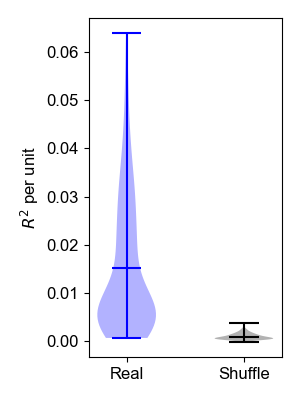

In [10]:
t = []
t_shuffle = []
for unit in range(n_units):
    t.append(su_cv_R_squared[unit][su_best_model[unit].astype(int)])
    t_shuffle.append(su_cv_R_squared_shuffle[unit][su_best_model_shuffle[unit].astype(int)])

fig, ax = plt.subplots(figsize=(3, 4))
parts = ax.violinplot([t, t_shuffle], showmeans=True, showextrema=True)

colors = ['b', 'k']
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    
if 'cbars' in parts:
    parts['cbars'].set_color(colors)
if 'cmins' in parts:
    parts['cmins'].set_color(colors)
if 'cmaxes' in parts:
    parts['cmaxes'].set_color(colors)
if 'cmedians' in parts:
    parts['cmedians'].set_color(colors)
elif 'cmeans' in parts:
    parts['cmeans'].set_color(colors)

plt.xticks([1, 2], ['Real', 'Shuffle'])
plt.ylabel('$R^2$ per unit')
plt.tight_layout()

#### Plotting event-triggered avg PSTH

In [24]:
pop_peth.shape

(177, 6257, 4)

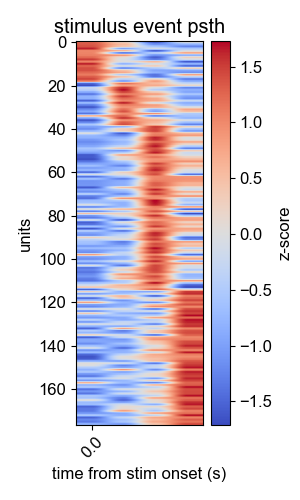

In [23]:
# Convolved with alpha function kernel
from spks.utils import alpha_function
binsize = bin_size
t_decay = 0.025
t_rise = 0.001
decay = t_decay / binsize
kern = alpha_function(int(decay * 15), t_rise=t_rise, t_decay=decay, srate=1./binsize)

pop_peth, timebin_edges, _ = population_peth(
        all_spike_times=spike_times_per_unit,
        alignment_times=all_stims,
        pre_seconds=0.,
        post_seconds=0.15,
        binwidth_ms=25.,
        pad=0,
        kernel=kern,
    )

mean_psth = np.mean(pop_peth, axis = 1)

from scipy.stats import zscore
normalized_mean_psth = zscore(mean_psth, axis=1, nan_policy='omit') #normalize each unit
peak_indices = np.argmax(normalized_mean_psth, axis=1)
peak_sort_indices = np.argsort(peak_indices) #row_sort_indices is for cumsum of model weights, peak_sort_indices is for earlier responses
sorted_psth = normalized_mean_psth[peak_sort_indices]


plt.figure(figsize=(3,5))
plt.imshow(sorted_psth, aspect='auto', cmap='coolwarm') # for sorting my model cumsum use `normalized_mean_psth[row_sort_indices]`
plt.colorbar(label = 'z-score')
plt.xticks(np.arange(0, n_timepoints, 5), (np.arange(0, n_timepoints, 5))*bin_size, rotation=45)
plt.xlabel('time from stim onset (s)')
plt.ylabel('units')
plt.title('stimulus event psth')
plt.tight_layout()
# plt.savefig(pjoin(save_dir, "peak_sort_stimulus_event_psth.png"), format='png', dpi=300, bbox_inches='tight')


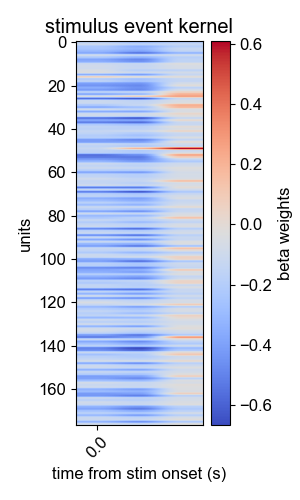

In [26]:
weights = models[best_model].coef_

row_cumsum = np.cumsum(weights[:,:n_timepoints], axis=1)
row_sort_indices = np.argsort(row_cumsum[:, -1])[::-1]

plt.figure(figsize=(3, 5))
plt.imshow(weights[peak_sort_indices], aspect='auto', cmap='coolwarm')
plt.colorbar(label = 'beta weights')
plt.xticks(np.arange(0, n_timepoints, 5), (np.arange(0, n_timepoints, 5))*bin_size, rotation=45)
plt.xlabel('time from stim onset (s)')
plt.ylabel('units')
plt.title('stimulus event kernel')
plt.tight_layout()
# plt.savefig(pjoin(save_dir, "stimulus_event_kernel_weights.png"), format='png', dpi=300, bbox_inches='tight')

#### Making sure stim alignment is correct

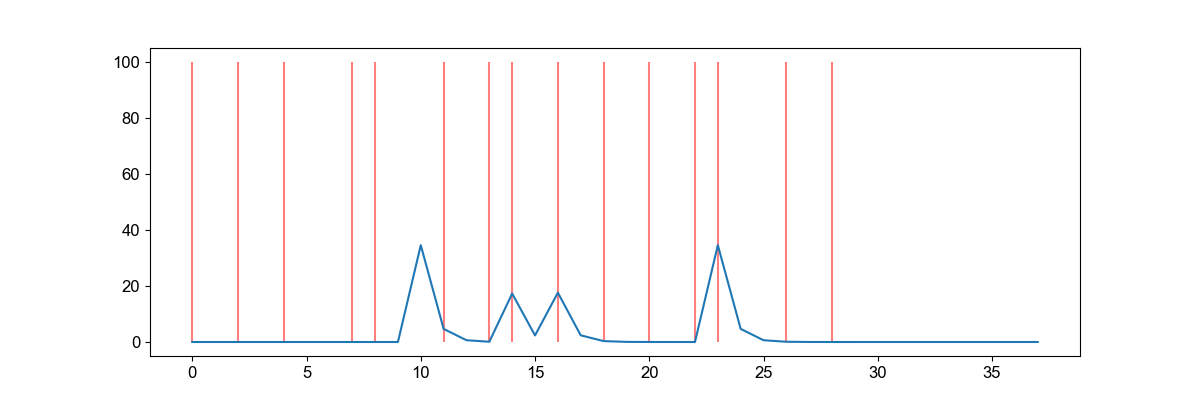

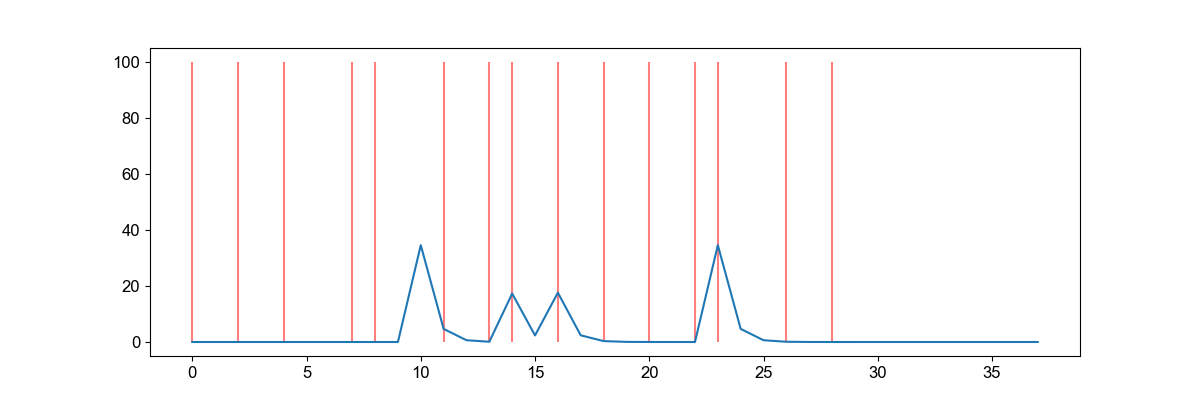

In [ ]:
#i want to plot the binned spike rate for the timebins around the events in all_stims[:15]
#find the indices of the timebins around the events
event_indices = np.searchsorted(time_bins[:-1], all_stims[:15], side='right') - 1

plt.figure(figsize=(12, 4))
plt.vlines(event_indices, ymin = 0, ymax = 100, color='r', alpha=0.5)
plt.plot(smoothed_binned_spike_rate[event_indices[0]:event_indices[-1]+10, peak_sort_indices[0]])

In [30]:
plt.figure(figsize=(6, 6))
ax = plt.gca()
plt.eventplot(all_stims[:15], color='k', lineoffsets=0.25, linelengths=0.5, linewidths=0.5, label='actual stims')
plt.eventplot(binned_spike_rate[:, peak_sort_indices], color='r', lineoffsets=1, linelengths=0.5, linewidths=0.5, label='model stims')
plt.xlabel('time (s)')
plt.ylabel('stims')
plt.legend()
plt.tight_layout()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x152e21000> (for post_execute):


KeyboardInterrupt: 